# Alpaca Paper Trading — Mean Reversion Strategy

**Three operating modes:**
1. **Replay Mode** — Replay historical data day-by-day through the live pipeline. Validates that live system matches backtest results.
2. **Shadow Mode** — Run on live Alpaca data but don't submit orders. Track hypothetical P&L. Build confidence before going live.
3. **Live Mode** — Submit real paper-trade orders to Alpaca.

**Workflow:**
- Cell 1–3: Setup, connection, universe selection
- Cell 4–5: Data fetch + signal generation (shared by all modes)
- Cell 5c: **Shadow Replay** — 1-year performance evaluation
- Cell 6–7: **Mode A: Replay** — historical validation + backtest comparison
- Cell 8: **Mode B: Shadow / Live** — daily trading execution
- Cell 9–10: Position dashboard + trade log export

> **Crypto test:** See `main_crypto_test.ipynb` for BTC/ETH live order validation.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 1: IMPORTS & SETUP
# ══════════════════════════════════════════════════════════════════════════════

import sys, os, time, logging, importlib
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure src/ is on the path
src_dir = Path.cwd() if Path.cwd().name == 'src' else Path.cwd() / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# ─── Strategy & backtest modules ───────────────────────────────────────────
from strategy_config import ConfigLoader
from strategies.mean_reversion import MeanReversionSignals, SignalConfig
from backtest.engine import BacktestEngine, BacktestConfig

# ─── Alpaca modules ────────────────────────────────────────────────────────
from connection.alpaca_connection import AlpacaConfig, AlpacaConnection, TradingMode
from data.alpaca_data import AlpacaDataAdapter
from execution.alpaca_executor import AlpacaExecutor, TradeDecision, TradeResult
from execution.simulation import SimulationEngine

# ─── Shared trading pipeline ──────────────────────────────────────────────
from trading.pipeline import (
    select_universe, refresh_universe_hurst,
    fetch_data, generate_signals,
    build_executor, build_simulation,
)
from trading.analysis import (
    plot_shadow_replay, print_monthly_returns, print_trade_summary,
    print_metrics_comparison, print_replay_trade_breakdown,
    plot_equity_comparison, plot_export_charts,
)
from trading.dashboard import show_dashboard

# ─── Logging ───────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s',
    datefmt='%H:%M:%S'
)

# ─── Load config ───────────────────────────────────────────────────────────
config = ConfigLoader()
signal_config = config.to_signal_config()
bt_config = config.to_backtest_config()
composite_weights = config.get_composite_weights()

print("✅ All modules loaded")
print(f"   Signal mode: {signal_config.signal_mode}")
print(f"   Kalman: {'ON' if signal_config.use_kalman else 'OFF'}")
print(f"   OU Gate: {'ON' if signal_config.use_predicted_return else 'OFF'}")
print(f"   Entry threshold: {bt_config.entry_threshold}")
print(f"   Exit threshold:  {bt_config.exit_threshold}")
print(f"   Stop loss: {bt_config.stop_loss_pct}")
print(f"   Max hold:  {bt_config.max_holding_days} days")

✅ All modules loaded
   Signal mode: gated
   Kalman: ON
   OU Gate: ON
   Entry threshold: 1.43
   Exit threshold:  0.5
   Stop loss: 0.1
   Max hold:  20 days


In [2]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 2: CONNECT TO ALPACA
# ══════════════════════════════════════════════════════════════════════════════
# Set trading mode here:
#   TradingMode.REPLAY  — historical replay (no API calls for orders)
#   TradingMode.SHADOW  — live data, simulated trades
#   TradingMode.LIVE    — submit real paper-trade orders

TRADING_MODE = TradingMode.REPLAY  # ← Change this as needed

# Load API keys from .env and create connection
alpaca_config = AlpacaConfig.from_env()
alpaca_config.trading_mode = TRADING_MODE

conn = AlpacaConnection(alpaca_config)
conn.test_connection()

print(f"\n🔧 Trading mode: {TRADING_MODE.value.upper()}")
if TRADING_MODE == TradingMode.REPLAY:
    print("   → Using historical data only. No Alpaca API orders.")
elif TRADING_MODE == TradingMode.SHADOW:
    print("   → Live data, simulated trades. No real orders submitted.")
else:
    print("   → ⚠️  LIVE MODE: Real paper-trade orders will be submitted!")

19:01:29 | connection.alpaca_connection | INFO | Trading client initialized (paper=True, mode=replay)


  ALPACA CONNECTION TEST
  Status:          AccountStatus.ACTIVE
  Mode:            PAPER
  Trading Mode:    REPLAY
  Cash:            $903,911.76
  Buying Power:    $1,904,509.52
  Portfolio Value: $1,000,621.77
  Market Open:     True
  Day Trades:      0
  PDT Flag:        False

🔧 Trading mode: REPLAY
   → Using historical data only. No Alpaca API orders.


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 3: SELECT TOP-60 UNIVERSE
# ══════════════════════════════════════════════════════════════════════════════

MAX_UNIVERSE = config.get('alpaca.max_universe_size', 60)

UNIVERSE = select_universe(config, max_symbols=MAX_UNIVERSE)

print(f"📊 Trading Universe ({len(UNIVERSE)} symbols):")
for i in range(0, len(UNIVERSE), 10):
    print(f"   {', '.join(UNIVERSE[i:i+10])}")

Total curated universe: 269 symbols
Computing Hurst exponents from local data...
Computed Hurst for 208 mean-reverting symbols

📊 Trading Universe (60 symbols):
   BBWI, KTOS, LUMN, FIVE, DUOL, NEOG, MPC, AFRM, CORT, CELH
   CSX, NPO, BOOT, LPX, CVX, F, ATKR, FTDR, CRWD, DV
   COP, TILE, PCVX, CARG, NSIT, PLAB, ASGN, PM, GTES, DY
   CXT, KO, RMBS, SMCI, ANF, MDLZ, CAT, DNOW, ABG, AMZN
   GFF, HQY, ASML, CI, TSLA, MNDY, ADP, EXLS, DD, ORLY
   GVA, PSX, PAYO, WDAY, GE, WFC, GM, ANDE, AAPL, PANW


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 4: FETCH DATA — MODE-AWARE CACHING
# ══════════════════════════════════════════════════════════════════════════════

# Adjust lookback based on mode
if TRADING_MODE == TradingMode.REPLAY:
    LOOKBACK_DAYS = 1825  # Full history for replay validation
else:
    LOOKBACK_DAYS = 365   # Just need recent data for signals

adapter = AlpacaDataAdapter(
    data_client=conn.data_client,
    data_feed=alpaca_config.data_feed,
    cache_dir=Path('../data/snapshots/alpaca_cache'),
)

print(f"Loading data for {len(UNIVERSE)} symbols ({TRADING_MODE.value.upper()} mode)...")
print(f"  Lookback: {LOOKBACK_DAYS} days (~{LOOKBACK_DAYS/365:.1f} years)")
print(f"  Data feed: {alpaca_config.data_feed.upper()}")

t0 = time.perf_counter()
price_df, volume_df, raw_bars = fetch_data(adapter, UNIVERSE, lookback_days=LOOKBACK_DAYS)
elapsed = time.perf_counter() - t0

trading_days = len(price_df)
trading_years = trading_days / 252

print(f"\n✅ Data ready in {elapsed:.1f}s")
print(f"   Date range : {price_df.index.min().date()} → {price_df.index.max().date()}")
print(f"   Trading days: {trading_days}  (~{trading_years:.1f} years)")
print(f"   Symbols OK  : {len(price_df.columns)}")
missing = set(UNIVERSE) - set(price_df.columns)
if missing:
    print(f"   Missing     : {', '.join(sorted(missing))}")
else:
    print(f"   Missing     : none")

# Update universe to only symbols with valid data
UNIVERSE = list(price_df.columns)

19:01:48 | connection.alpaca_connection | INFO | Data client initialized
19:01:48 | data.alpaca_data | INFO | Loaded 30 symbols from cache


Loading data for 60 symbols (REPLAY mode)...
  Lookback: 1825 days (~5.0 years)
  Data feed: IEX
  Cache dir: ../data/snapshots/alpaca_cache
  Stale cache: NOT ALLOWED

   📦 Cache hit: 30 symbols — up to date, skipping API
   🔍 Cache miss: 30 symbols need full fetch
   🌐 Fetching 30 symbols from API (1825 days)...


19:01:49 | data.alpaca_data | INFO | Fetched data for 30/30 symbols
19:01:49 | data.alpaca_data | INFO | Pipeline data: 1254 days × 60 symbols (2021-02-22 to 2026-02-18)


   ✅ Fetched 30 symbols in 0.7s

✅ Data ready in 0.9s
   Date range : 2021-02-22 → 2026-02-18
   Trading days: 1254  (~5.0 years)
   Symbols OK  : 60
   Missing     : none


19:01:49 | data.alpaca_data | INFO | Cached 60 symbols to ../data/snapshots/alpaca_cache


   💾 Cache saved → next run will be near-instant


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 5: GENERATE SIGNALS
# ══════════════════════════════════════════════════════════════════════════════

print(f"Generating signals for {len(UNIVERSE)} symbols...")
t0 = time.perf_counter()

signal_df, zscore_df = generate_signals(config, price_df, volume_df)

# Align price/volume to signal index
price_df = price_df.loc[signal_df.index, signal_df.columns]
volume_df = volume_df.loc[signal_df.index, signal_df.columns]

elapsed = time.perf_counter() - t0
print(f"✅ Signals generated for {len(signal_df.columns)} symbols in {elapsed:.1f}s")

# Show today's signals snapshot
latest_date = signal_df.index[-1]
latest_signals = signal_df.loc[latest_date].dropna().sort_values()
print(f"\n📡 Latest signals ({latest_date.date()}):")
print(f"   Strong longs  (signal < -{bt_config.entry_threshold}): "
      f"{(latest_signals < -bt_config.entry_threshold).sum()}")
print(f"   Strong shorts (signal > +{bt_config.entry_threshold}): "
      f"{(latest_signals > bt_config.entry_threshold).sum()}")
print(f"   Signal range: [{latest_signals.min():.2f}, {latest_signals.max():.2f}]")

Generating signals for 60 symbols...
  Weights: {'bollinger': 0.0, 'rsi_divergence': 0.75, 'rsi_level': 0.0}
  Mode: gated | Gate: rsi_divergence

  Processed 10/60...


  Processed 20/60...
  Processed 30/60...
  Processed 40/60...
  Processed 50/60...
  Processed 60/60...

✅ Signals generated for 60 symbols in 1.0s

📡 Latest signals (2026-02-18):
   Strong longs  (signal < -1.43): 0
   Strong shorts (signal > +1.43): 0
   Signal range: [0.00, 1.28]


## Shadow Replay — 1-Year Performance

Runs the SHADOW execution pipeline over the last 252 trading days (~1 year) to observe how trades would have performed historically. Uses the same signal generation, entry/exit logic, and position sizing as daily shadow mode, but replayed over the full year.

🔮 SHADOW REPLAY — 1-Year Performance Evaluation
───────────────────────────────────────────────────────
   Period     : 2025-02-18 → 2026-02-18
   Days       : 252  (~1.0 years)
   Capital    : $100,000
   Commission : 0.10% | Slippage: 0.05%
   Universe   : 60 symbols


  HISTORICAL REPLAY
  Period: 2025-02-18 → 2026-02-18 (252 days)
  Universe: 60 symbols
  Initial Capital: $100,000

  Day 250/252 | 2026-02-13 | Equity: $183,756 (+83.8%) | Positions: 2 | Trades: 541

  SIMULATION RESULTS
  Final Equity:    $184,005.19
  Total Return:    +84.09%
  Sharpe Ratio:    3.83
  Max Drawdown:    -5.28%
  Total Trades:    546
  Win Rate:        62.8%
  Avg Trade P&L:   +1.25%
  Avg Winner:      +3.52%
  Avg Loser:       -2.59%
  Open Positions:  1

⏱️  Shadow replay completed in 0.6s


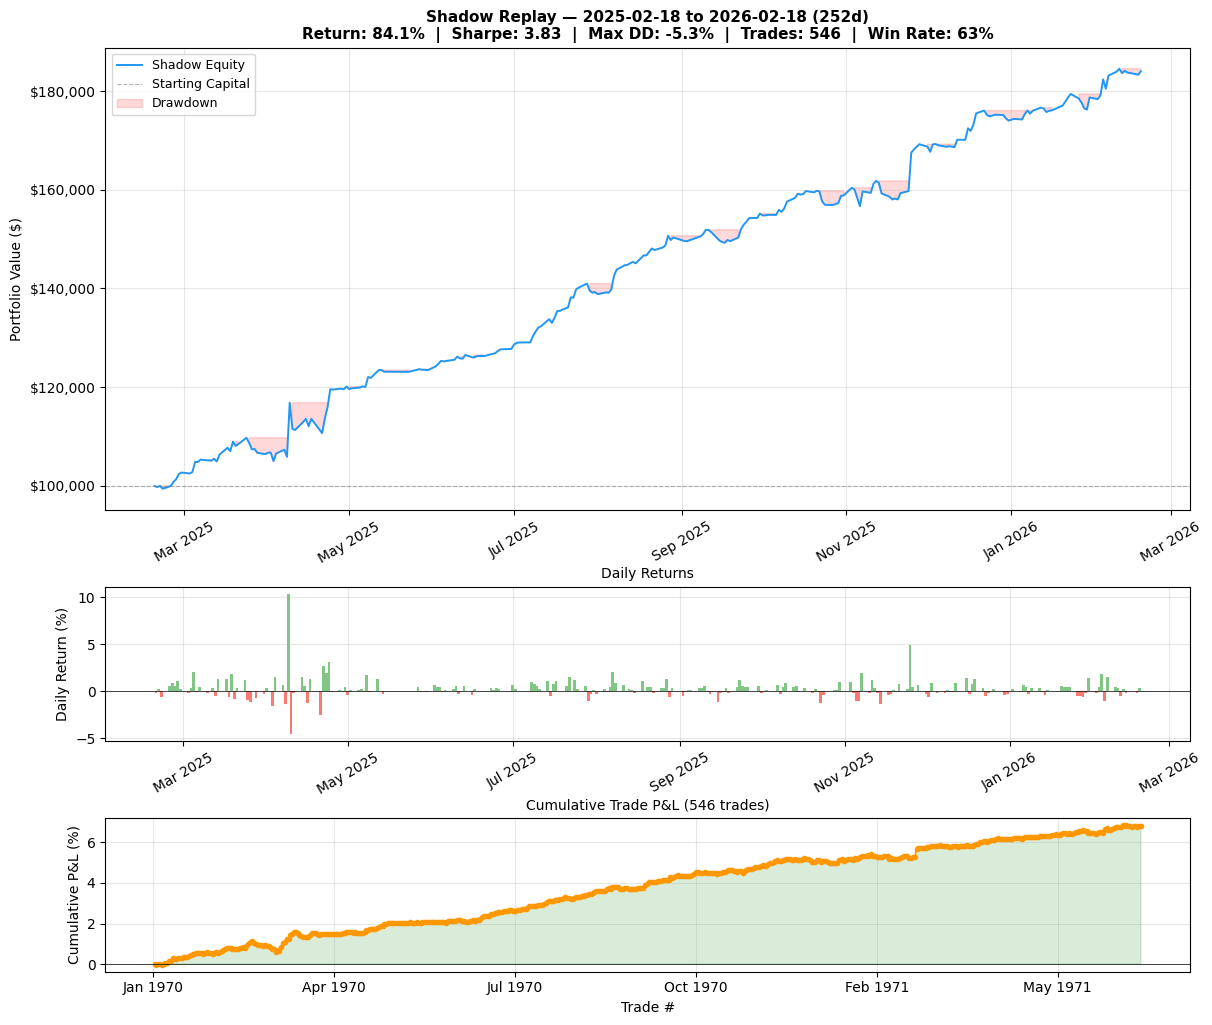

📊 Chart saved → data/snapshots/shadow_replay_1yr.png

📅 Monthly Returns:
────────────────────────────────────────
   2025-02  🟢 +  2.73%  █████
   2025-03  🟢 +  3.63%  ███████
   2025-04  🟢 + 12.87%  █████████████████████████
   2025-05  🟢 +  2.75%  █████
   2025-06  🟢 +  3.50%  ███████
   2025-07  🟢 +  9.02%  ██████████████████
   2025-08  🟢 +  7.94%  ███████████████
   2025-09  🟢 +  3.23%  ██████
   2025-10  🟢 +  2.36%  ████
   2025-11  🟢 +  6.54%  █████████████
   2025-12  🟢 +  2.83%  █████
   2026-01  🟢 +  2.69%  █████
   2026-02  🟢 +  2.98%  █████
────────────────────────────────────────
   Total       +63.07%

📋 Top/Bottom Trades:
─────────────────────────────────────────────────────────────────
   Best:
     ANF    long    +0.37%  2025-11-24 → 2025-11-25
     AFRM   long    +0.23%  2025-04-04 → 2025-04-09
     BBWI   long    +0.17%  2025-04-08 → 2025-04-09
     CELH   long    +0.17%  2025-08-05 → 2025-08-07
     MNDY   long    +0.16%  2025-04-04 → 2025-04-09
   Worst:
     BBWI 

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 5c: 1-YEAR SHADOW REPLAY
# ══════════════════════════════════════════════════════════════════════════════

shadow_replay_executor = build_executor(conn, bt_config, TradingMode.SHADOW)
shadow_replay_sim = build_simulation(shadow_replay_executor, bt_config, TradingMode.SHADOW)

# ─── 1-year window ────────────────────────────────────────────────────────
REPLAY_WINDOW = 252
shadow_start = signal_df.index[-REPLAY_WINDOW] if len(signal_df) > REPLAY_WINDOW else signal_df.index[0]
shadow_end = signal_df.index[-1]
trading_days = len(signal_df.loc[shadow_start:shadow_end])

print(f"🔮 SHADOW REPLAY — 1-Year Performance Evaluation")
print(f"{'─'*55}")
print(f"   Period  : {shadow_start.date()} → {shadow_end.date()}  ({trading_days}d)")
print(f"   Capital : ${bt_config.initial_capital:,.0f}  |  Universe: {len(UNIVERSE)} symbols\n")

t0 = time.perf_counter()
shadow_replay_results = shadow_replay_sim.run_replay(
    price_df=price_df, signal_df=signal_df, volume_df=volume_df,
    exit_signal_df=zscore_df, config=bt_config,
    start_date=shadow_start, end_date=shadow_end, verbose=True,
)
print(f"\n⏱️  Completed in {time.perf_counter() - t0:.1f}s")

# ─── Charts & reports (from trading.analysis) ─────────────────────────────
plot_shadow_replay(
    shadow_replay_results, bt_config, shadow_start, shadow_end,
    n_symbols=len(UNIVERSE),
    save_path=Path('../data/snapshots/shadow_replay_1yr.png'),
)
print_monthly_returns(shadow_replay_results.get('returns'))
print_trade_summary(shadow_replay_results.get('trades_df'))

## Mode A: Historical Replay

Replays historical data day-by-day through the live pipeline. Validates that the live execution system produces the same signals and trades as the backtest engine. Run this once before trusting the live system.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 6: HISTORICAL REPLAY — MAXIMUM WINDOW
# ══════════════════════════════════════════════════════════════════════════════

# Create executor+sim in REPLAY mode
replay_config = AlpacaConfig.from_env()
replay_config.trading_mode = TradingMode.REPLAY
replay_conn = AlpacaConnection(replay_config)

replay_executor = build_executor(replay_conn, bt_config, TradingMode.REPLAY)
sim = build_simulation(replay_executor, bt_config, TradingMode.REPLAY)

# ── Use ALL available data (skip first 252 days for signal warmup) ──
WARMUP_DAYS = 252
replay_start = signal_df.index[WARMUP_DAYS] if len(signal_df) > WARMUP_DAYS else signal_df.index[0]
replay_end = signal_df.index[-1]
replay_trading_days = len(signal_df.loc[replay_start:replay_end])
replay_years = replay_trading_days / 252

print(f"🔄 Running replay over MAXIMUM available window:")
print(f"   Period     : {replay_start.date()} → {replay_end.date()}")
print(f"   Days       : {replay_trading_days}  (~{replay_years:.1f} years)")
print(f"   Capital    : ${bt_config.initial_capital:,.0f}")
print()

t0 = time.perf_counter()
replay_results = sim.run_replay(
    price_df=price_df, signal_df=signal_df, volume_df=volume_df,
    exit_signal_df=zscore_df, config=bt_config,
    start_date=replay_start, end_date=replay_end, verbose=True,
)
print(f"\n⏱️  Replay completed in {time.perf_counter() - t0:.1f}s")

🔄 Running replay over MAXIMUM available window:
   Period     : 2022-02-18 → 2026-02-18
   Days       : 1002  (~4.0 years)
   Warmup skip: first 252 signal days
   Capital    : $100,000
   Commission : 0.10% | Slippage: 0.05%


  HISTORICAL REPLAY
  Period: 2022-02-18 → 2026-02-18 (1002 days)
  Universe: 60 symbols
  Initial Capital: $100,000

  Day 250/1002 | 2023-02-16 | Equity: $336,717 (+236.7%) | Positions: 3 | Trades: 795
  Day 500/1002 | 2024-02-15 | Equity: $635,394 (+535.4%) | Positions: 4 | Trades: 1328
  Day 750/1002 | 2025-02-14 | Equity: $1,243,100 (+1143.1%) | Positions: 2 | Trades: 1946
  Day 1000/1002 | 2026-02-13 | Equity: $2,324,494 (+2224.5%) | Positions: 2 | Trades: 2484

  SIMULATION RESULTS
  Final Equity:    $2,327,611.86
  Total Return:    +2228.31%
  Sharpe Ratio:    4.80
  Max Drawdown:    -9.52%
  Total Trades:    2489
  Win Rate:        64.4%
  Avg Trade P&L:   +1.41%
  Avg Winner:      +3.52%
  Avg Loser:       -2.43%
  Open Positions:  1

⏱️  Replay comple

Running backtest on same period for comparison...

════════════════════════════════════════════════════════════════════════
  METRIC                         REPLAY (Live Pipe)            BACKTEST
════════════════════════════════════════════════════════════════════════
  Period                         2022-02-18 → 2026-02-18  2022-02-18 → 2026-02-18
  Trading Days                                 1002                1002
  ─── Returns ───               
  Total Return                             +699.24%            +703.34%
  Annualized Return                         +68.66%             +68.88%
  Final Equity                          $799,118.26         $803,344.26
  ─── Risk ───                  
  Sharpe Ratio                                4.446               4.434
  Sortino Ratio                                 n/a               9.163
  Calmar Ratio                                  n/a              15.363
  Max Drawdown                               -4.49%               4.48%
  Max D

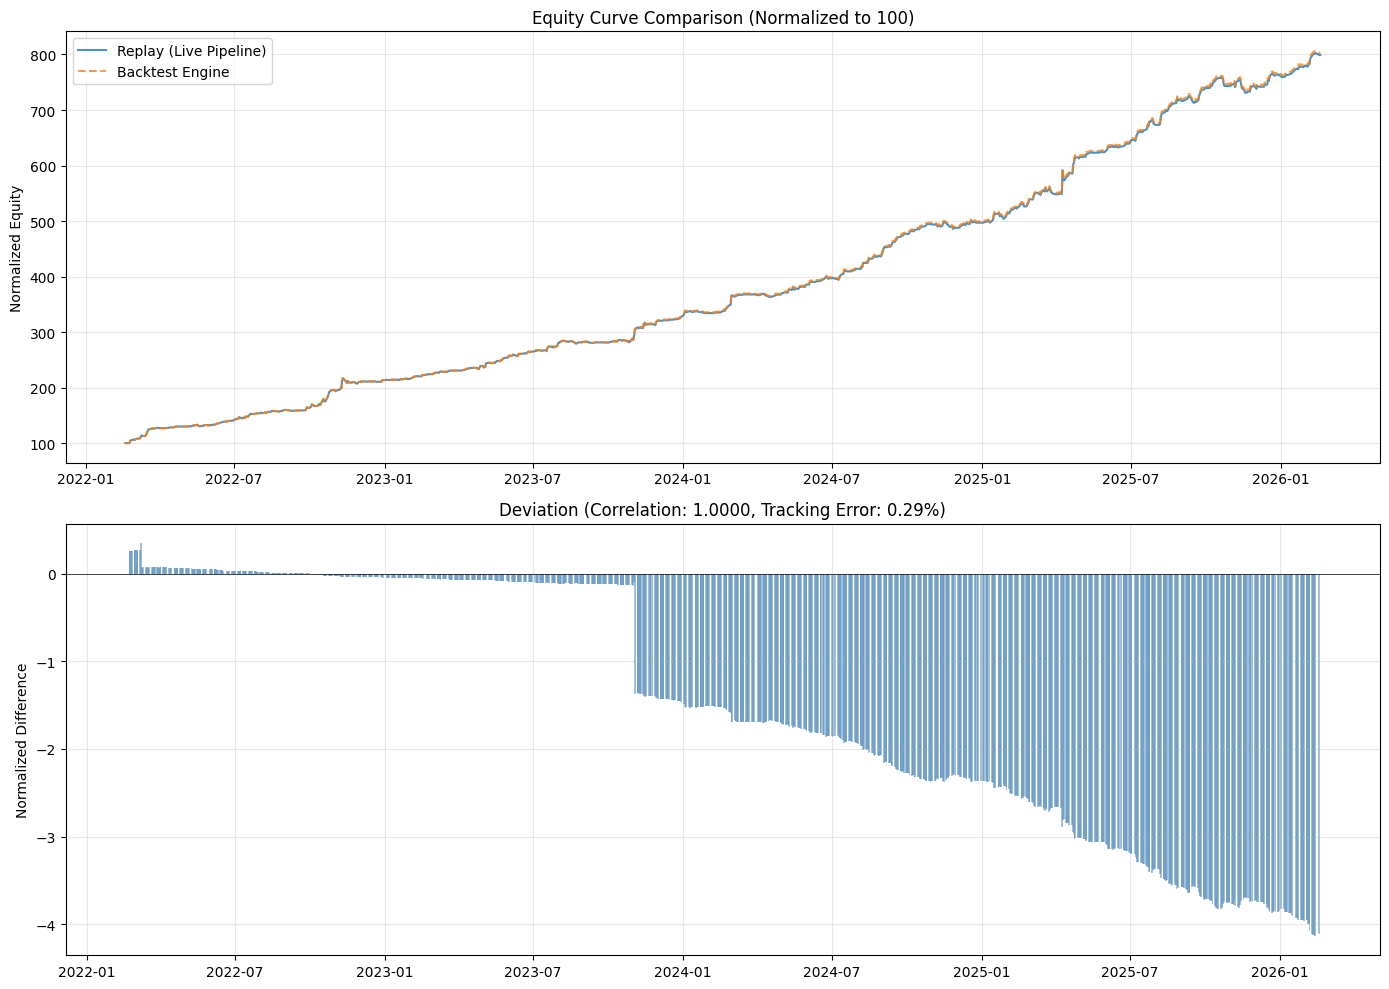


📊 Alignment Metrics:
   Correlation       : 1.0000
   Tracking Error    : 0.29% (annualized)
   Max Deviation     : 4.13
   Avg Deviation     : 1.50
   Overlapping Days  : 1002

✅ Strong match! Live pipeline is consistent with backtest.


In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 7: DETAILED REPLAY vs BACKTEST COMPARISON
# ══════════════════════════════════════════════════════════════════════════════

print("Running backtest on same period for comparison...\n")

bt_engine = BacktestEngine(bt_config)
bt_results = bt_engine.run_backtest(
    price_df.loc[replay_start:],
    signal_df.loc[replay_start:],
    volume_df.loc[replay_start:],
    exit_signal_data=zscore_df.loc[replay_start:],
)

# ─── Side-by-side comparison ──────────────────────────────────────────────
print_metrics_comparison(replay_results, bt_results, replay_start, replay_end)
print_replay_trade_breakdown(replay_results)
plot_equity_comparison(sim, bt_results.equity_curve, replay_results)

## Mode B: Shadow / Live Daily Trading

Run this section daily. In **Shadow mode**, it generates signals and tracks hypothetical trades without submitting orders. In **Live mode**, it submits real paper-trade orders to Alpaca.

**Daily workflow:** Run cells 1–5 (setup + data + signals), then cell 8 below.

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 8: DAILY SHADOW / LIVE EXECUTION
# ══════════════════════════════════════════════════════════════════════════════
# Processes today's signals. SHADOW → hypothetical trades. LIVE → real orders.

# ─── Initialize or restore shadow state ────────────────────────────────────
SHADOW_LOG = Path('../data/snapshots/shadow_state.csv')

executor = build_executor(conn, bt_config, TRADING_MODE)
shadow_sim = build_simulation(executor, bt_config, TRADING_MODE)

# Restore previous shadow positions if they exist
if SHADOW_LOG.exists() and TRADING_MODE == TradingMode.SHADOW:
    prev = pd.read_csv(SHADOW_LOG)
    if not prev.empty:
        from execution.simulation import SimulatedPosition
        for _, row in prev.iterrows():
            shadow_sim.positions[row['symbol']] = SimulatedPosition(
                symbol=row['symbol'],
                qty=int(row['qty']),
                side=row['side'],
                entry_price=float(row['entry_price']),
                entry_date=pd.Timestamp(row['entry_date']),
                signal_strength=float(row.get('signal_strength', 0)),
                current_price=float(row.get('current_price', row['entry_price'])),
            )
        shadow_sim.cash -= sum(
            p.entry_price * abs(p.qty) for p in shadow_sim.positions.values()
            if p.side == 'long'
        )
        print(f"♻️  Restored {len(shadow_sim.positions)} shadow positions")

# ─── Process today ─────────────────────────────────────────────────────────
today = signal_df.index[-1]
print(f"\n{'═'*60}")
print(f"  DAILY EXECUTION — {today.date()} — {TRADING_MODE.value.upper()} MODE")
print(f"{'═'*60}")

if TRADING_MODE in (TradingMode.SHADOW, TradingMode.REPLAY):
    shadow_sim.process_shadow_day(
        date=today, signal_df=signal_df, price_df=price_df,
        volume_df=volume_df, exit_signal_df=zscore_df,
        config=bt_config, verbose=True,
    )

    # Save shadow state for next run
    if shadow_sim.positions:
        state_rows = []
        for sym, pos in shadow_sim.positions.items():
            state_rows.append({
                'symbol': pos.symbol, 'qty': pos.qty, 'side': pos.side,
                'entry_price': pos.entry_price, 'entry_date': pos.entry_date,
                'signal_strength': pos.signal_strength,
                'current_price': pos.current_price,
            })
        pd.DataFrame(state_rows).to_csv(SHADOW_LOG, index=False)
        print(f"\n💾 Shadow state saved ({len(state_rows)} positions)")
    else:
        if SHADOW_LOG.exists():
            SHADOW_LOG.unlink()
        print("\n💾 No open positions — shadow state cleared")

else:
    # LIVE mode: generate decisions and submit orders
    current_positions = {}
    for pos in conn.get_positions():
        current_positions[pos['symbol']] = {
            'qty': int(pos['qty']),
            'side': 'long' if int(pos['qty']) > 0 else 'short',
            'entry_price': float(pos['avg_entry_price']),
            'entry_date': pd.Timestamp.now() - pd.Timedelta(days=1),
        }

    decisions = executor.generate_decisions_from_signals(
        signal_df=signal_df, price_df=price_df, volume_df=volume_df,
        exit_signal_df=zscore_df, date=today,
        current_positions=current_positions, config=bt_config,
    )

    if decisions:
        print(f"\n📋 {len(decisions)} trade decisions:")
        for d in decisions:
            print(f"   {d.action.upper():6s} {d.symbol:6s} x{d.target_qty:4d}  "
                  f"signal={d.signal_strength:+.3f}  {d.reason}")

        current_prices = adapter.get_latest_prices([d.symbol for d in decisions])
        results = executor.execute_decisions(decisions, current_prices)

        print(f"\n📊 Execution results:")
        for r in results:
            status_icon = '✅' if r.status in ('filled', 'submitted') else '❌'
            print(f"   {status_icon} {r.decision.symbol} → {r.status} "
                  f"@ ${r.filled_price or 0:.2f}")
    else:
        print("\n😴 No trade signals today")

    account = conn.get_account()
    print(f"\n💰 Account: ${account['portfolio_value']:,.2f} "
          f"(cash: ${account['cash']:,.2f})")


════════════════════════════════════════════════════════════
  DAILY EXECUTION — 2026-02-18 — REPLAY MODE
════════════════════════════════════════════════════════════

── Shadow Day: 2026-02-18 ──
  Equity: $100,000.00 (daily: +0.000%)
  Positions: 0 (0L / 0S)
  Signals > threshold: 0

💾 No open positions — shadow state cleared


## Monitoring & Export

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 9: POSITION MONITORING DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════

active_sim = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)

show_dashboard(
    sim_engine=active_sim,
    connection=conn,
    mode=TRADING_MODE,
    signal_df=signal_df,
    entry_threshold=bt_config.entry_threshold,
)


══════════════════════════════════════════════════════════════════════
  POSITION DASHBOARD — 2026-02-18 17:57
══════════════════════════════════════════════════════════════════════

  Mode: REPLAY | Equity: $100,000.00 | Cash: $100,000.00
  Open positions: 0
  Completed trades: 0


Equity curve exported: ../data/snapshots/trading_logs/equity_replay_20260218_1757.csv (1 days)
📈 Equity curve: ../data/snapshots/trading_logs/equity_replay_20260218_1757.csv


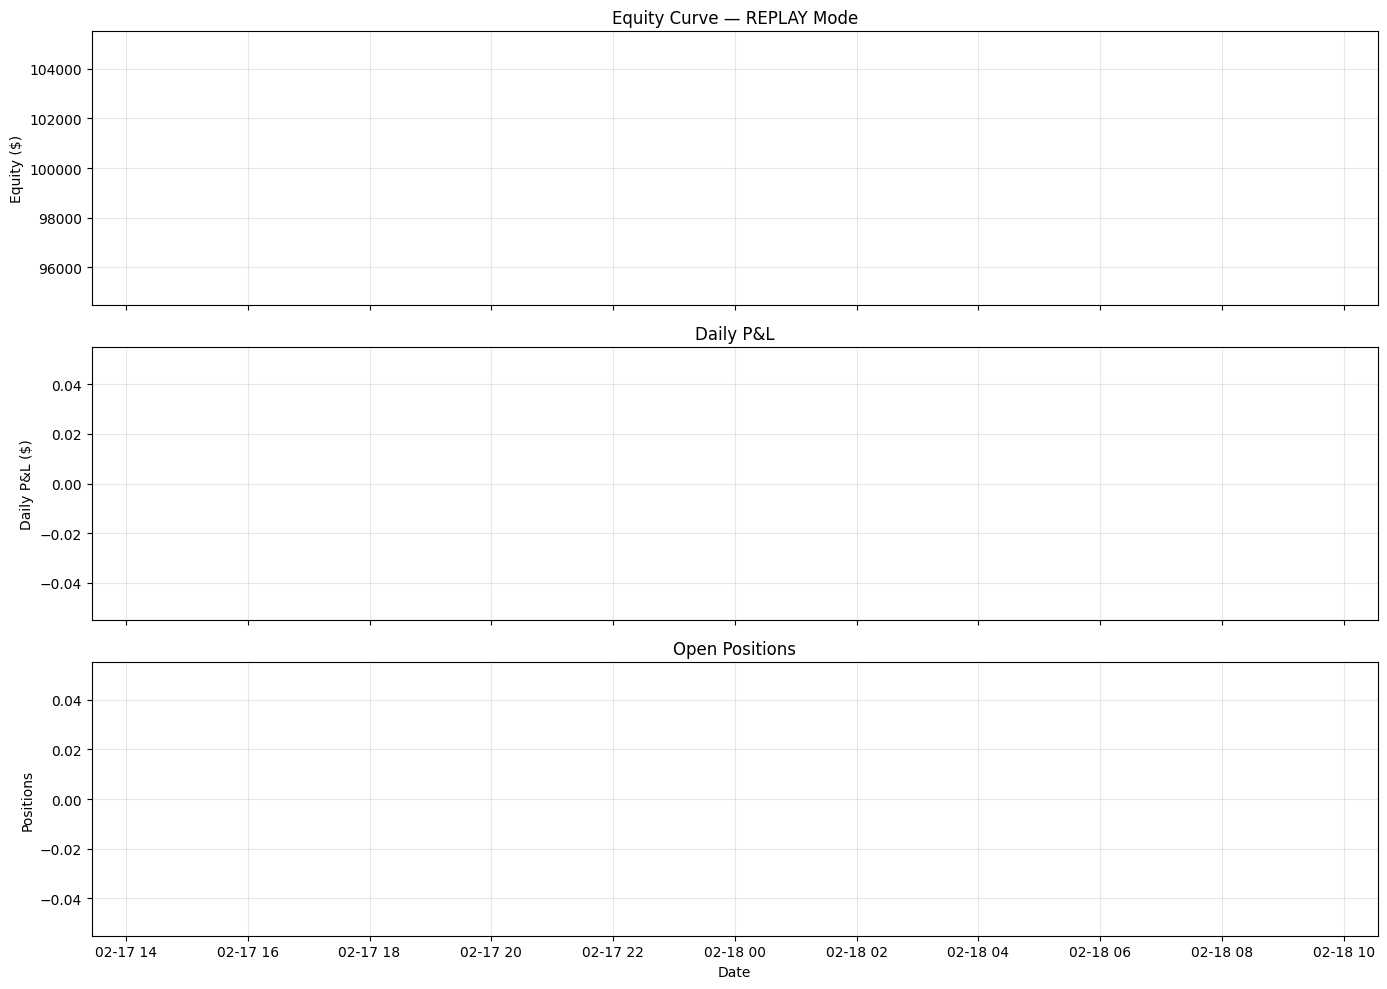

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# CELL 10: EXPORT TRADE LOGS & EQUITY CURVES
# ══════════════════════════════════════════════════════════════════════════════

export_dir = Path('../data/snapshots/trading_logs')
export_dir.mkdir(parents=True, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

active = shadow_sim if 'shadow_sim' in dir() else (sim if 'sim' in dir() else None)

if active and active.completed_trades:
    trade_path = export_dir / f'trades_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_trade_log(trade_path)
    print(f"📄 Trade log: {trade_path}")

if active and active.daily_snapshots:
    equity_path = export_dir / f'equity_{TRADING_MODE.value}_{timestamp}.csv'
    active.export_equity_curve(equity_path)
    print(f"📈 Equity curve: {equity_path}")

    snapshots_df = pd.DataFrame([
        {'date': s.date, 'equity': s.equity, 'daily_pnl': s.daily_pnl,
         'n_positions': s.n_positions, 'trades_entered': s.trades_entered,
         'trades_exited': s.trades_exited}
        for s in active.daily_snapshots
    ]).set_index('date')

    plot_export_charts(snapshots_df, TRADING_MODE.value)
else:
    print("No trading data to export yet. Run replay or shadow mode first.")